# Preprocessing

## imports

In [ ]:
from google.colab import files
import re
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import string
import gensim
from gensim.models import word2vec


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
uploaded = files.upload()

Saving blyad.txt to blyad.txt
Saving blyat.txt to blyat.txt


In [ ]:
!pip install stanza

     |████████████████████████████████| 286kB 6.5MB/s 


In [ ]:
import stanza
stanza.download('ru')
nlp = stanza.Pipeline('ru')

2021-05-29 14:35:47 INFO: Downloading default packages for language: ru (Russian)...
2021-05-29 14:37:40 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-05-29 14:37:40 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2021-05-29 14:37:40 INFO: Use device: cpu
2021-05-29 14:37:40 INFO: Loading: tokenize
2021-05-29 14:37:40 INFO: Loading: pos
2021-05-29 14:37:41 INFO: Loading: lemma
2021-05-29 14:37:41 INFO: Loading: depparse
2021-05-29 14:37:41 INFO: Loading: ner
2021-05-29 14:37:43 INFO: Done loading processors!


## Read files

In [ ]:
with open('blyat.txt', 'r', encoding='utf-8') as f:
  f = f.read()
corpus1 = f.split('\n')

with open('blyad.txt', 'r', encoding='utf-8') as fl:
  fl = fl.read()

corpus2 = fl.split('\n')
corpus = corpus1 + corpus2
ids = []
texts = []

for c in corpus:
  id = re.findall('(\d+)#', c)
  if id:
    ids.append(id[0])
    text = re.findall('#####(.+)', c)
    if text:
      texts.append(text[0])
len(ids), len(texts)

(77499, 77499)

In [ ]:
df = pd.DataFrame({'user_id': ids, 'comment': texts})
df.head(5)

,user_id,comment
0,384019852,"чего блять,животных то в эту хуйню не впутывайте"
1,484456161,"[id559572241|Тимур], че блять за хуево боново ..."
2,180077196,Опять Власова приплели?! Да оставьте вы его уж...
3,325242759,П*утин Нет блять бл*ять
4,408270835,"[id331273537|Павел], Ты чё,блять,еблан? Как то..."


In [ ]:
def get_left_context(comment):
  comment = comment.translate(str.maketrans('', '', string.punctuation))
  comment = comment.lower()
  lc = re.findall('(.+)блядь', comment)
  if lc:
    return lc[0]
  else:
    lc = re.findall('(.+)блять', comment)
    if lc:
      return lc[0]
    else:
      return None

def get_right_context(comment):
  comment = comment.translate(str.maketrans('', '', string.punctuation))
  comment = comment.lower()
  rc = re.findall('блядь(.+)', comment)
  if rc:
    return rc[0]
  else:
    rc = re.findall('(.+)блять', comment)
    if rc:
      return rc[0]
    else:
      return None


In [ ]:
df['left_context'] = df['comment'].apply(get_left_context)

In [ ]:
df['right_context'] = df['comment'].apply(get_right_context)

In [ ]:
df.sample(5)

,user_id,comment,left_context,right_context
7132,312050982,"[id456443729|Jacob], миллиарды лет назад может...",None,None
2017,617512433,ПХАХАХВХВХААХАХАХ БЛЯДЬ,пхахахвхвхаахахах,None
2298,217574076,блядь т̛̤͓̙̺ё̡̯̥͖͚͚͎͟͝м̴̸̙̼н̛҉͏̞̻͓а̨̥͍̯͇͔͕̞я͏̟...,None,т̛̤͓̙̺ё̡̯̥͖͚͚͎͟͝м̴̸̙̼н̛҉͏̞̻͓а̨̥͍̯͇͔͕̞я͏̟̞̫̤̭ ...
4752,406431075,Смерть отца Хабиба - первое поражение Хабиба. ...,смерть отца хабиба первое поражение хабиба чт...,несёте как вы аще выстроили эту цепочку у себ...
9911,416314785,Ну послушал я этого уебана и заценил мотораму....,ну послушал я этого уебана и заценил мотораму ...,говно


# word2vec

In [ ]:
corp = ' '.join(corpus)
corp = re.sub('#', '', corp)
corp = re.sub('\[.+?\]', '', corp)
corp = corp.lower()
corp = re.sub('\d+', ' ', corp)
corp = re.sub('[-*]', '', corp)

corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', corp)

# corp = corp.translate(str.maketrans('', '', string.punctuation))
words = re.findall('[А-Яа-я]+', corp)
corp = ' '.join(words)
corp[:300]

'чего блять животных то в эту хуйню не впутывайте че блять за хуево боново собрание опять власова приплели да оставьте вы его уже блять в покое лет как помер дайте человеку спокойно в земле погнить путин нет блять блять ты ч блять еблан как то что они гдето там купаются относится к менталитету а то ч'

In [ ]:
with open('corpus.txt', 'w', encoding='utf-8') as fi:
  fi.write(corp)

In [ ]:
f = 'corpus.txt'
data = gensim.models.word2vec.LineSentence(f)

In [ ]:
%time model = gensim.models.Word2Vec(data, size=300, window=9, min_count=2)

CPU times: user 44.2 s, sys: 347 ms, total: 44.6 s
Wall time: 28.8 s


In [ ]:
model.init_sims(replace=True)
model_path = "model.bin"

print("Saving model...")
model.wv.save_word2vec_format(model_path, binary=True)

Saving model...


In [ ]:
len(model.wv.vocab)

46414

In [ ]:
model.wv.most_similar("блять", topn=30)

[('блядь', 0.953029453754425),
 ('ой', 0.8634277582168579),
 ('админ', 0.8477699756622314),
 ('фу', 0.8359435796737671),
 ('ору', 0.8198147416114807),
 ('пожалуйста', 0.8077038526535034),
 ('пиздец', 0.8048432469367981),
 ('блин', 0.803010106086731),
 ('смешно', 0.8026494383811951),
 ('жиза', 0.7997477054595947),
 ('господи', 0.793633222579956),
 ('да', 0.7832447290420532),
 ('спасибо', 0.777649998664856),
 ('боже', 0.7718039751052856),
 ('ваще', 0.7698826789855957),
 ('усну', 0.766508162021637),
 ('байт', 0.763473629951477),
 ('жожа', 0.7622077465057373),
 ('объясните', 0.7615460157394409),
 ('какой', 0.7593280076980591),
 ('воскрес', 0.7593044638633728),
 ('ж', 0.7550382018089294),
 ('теперь', 0.7541475296020508),
 ('всмысле', 0.7530757188796997),
 ('гусли', 0.7514474391937256),
 ('хахахаахахха', 0.7510424852371216),
 ('апреля', 0.7501664757728577),
 ('сука', 0.7490440607070923),
 ('умер', 0.7479289770126343),
 ('нимагу', 0.7475000619888306)]

In [ ]:
model.wv.most_similar("блядь", topn=30)

[('блять', 0.9530293345451355),
 ('админ', 0.8685410618782043),
 ('ой', 0.8377580642700195),
 ('фу', 0.8260373473167419),
 ('ору', 0.822340190410614),
 ('блин', 0.8148708343505859),
 ('пожалуйста', 0.8085808753967285),
 ('жиза', 0.8061694502830505),
 ('господи', 0.8024725317955017),
 ('пиздец', 0.8015351295471191),
 ('объясните', 0.801510214805603),
 ('смешно', 0.8002269268035889),
 ('байт', 0.7989557981491089),
 ('клан', 0.7984354496002197),
 ('всмысле', 0.7950351238250732),
 ('ваще', 0.7933325171470642),
 ('умер', 0.7879326939582825),
 ('боже', 0.7862975597381592),
 ('эф', 0.7838088870048523),
 ('мерзость', 0.7835944294929504),
 ('мемам', 0.7794234156608582),
 ('хахахаахахха', 0.7790176272392273),
 ('фото', 0.7776024341583252),
 ('пришельцы', 0.7774183750152588),
 ('глухой', 0.7773652076721191),
 ('противный', 0.776656448841095),
 ('админы', 0.7763301730155945),
 ('да', 0.7757611870765686),
 ('какой', 0.7733303308486938),
 ('рифмы', 0.7732175588607788)]

In [ ]:
model.wv.words_closer_than("блядь", "блять")

[]

В корпусе нет более семантически близких слов

In [ ]:
model.wv.similarity('блядь', 'шлюха')

0.51888794

In [ ]:
model.wv.similarity('блять', 'шлюха')

0.4612355

In [ ]:
uploaded = files.upload()

In [ ]:
df_meta = pd.read_csv('projectt.csv', sep='\t')

In [ ]:
def blyadt(text):
  blyat = re.findall('блять', text.lower())
  blyad = re.findall('блядь', text.lower())
  if blyat and blyad:
    return 'both'
  elif blyat:
    return 'блять'
  elif blyad:
    return 'блядь'
  else:
    return None

In [ ]:
df_meta['type'] = df_meta['Tetx'].progress_apply(blyadt)

In [ ]:
df_meta.sample(5)

,Id,Tetx,City,Sex,Bdate,type
15508,545734880,нет блять родилаона жирнодей,Surgut,2,22.12.2002,блять
8574,646325235,"[id153949405|Александр], жирная блядина, разло...",-,1,29.3.1997,None
74513,404974946,"[id297868401|Федор], и тут ты доебался ну что ...",Dmitrov,1,14.12.1999,блять
49057,363160221,А там блять только ружья,-,2,-,блять
26026,131961980,Кому это надо... треки на 1.5 минуты блять? я ...,Krasnoyarsk,2,27.11.1995,блять


In [ ]:
blyat_df = df_meta[df_meta['type'] == 'блять']
blyad_df = df_meta[df_meta['type'] == 'блядь']
print(blyat_df.shape, blyad_df.shape)

(66516, 6) (10084, 6)


# TM

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 8.2MB 9.2MB/s 


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from google.colab import files

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stopwords_ = stopwords.words('russian')
stopwords_.extend(['я', 'ты', 'он', 'она', 'твой', 'мой', 'они', 'это', 'наш', 'ваш',
                   'весь', 'все', 'свой', 'всё', 'ещё', 'оно', 'её', 'нибыть', 'лишь', 'очень', 'пусть'])

In [ ]:
def preprocess_text(texts_list):
  texts_list = [t for t in texts_list if t]   # getting rid of empty instances
  texts = [re.sub('\d+', '', each) for each in texts_list] # getting rid of numbers
  texts = [re.sub('[A-Za-z]', '', each) for each in texts]   # getting rid of links

  texts = [re.sub('\[.+?\]', ' ', each) for each in texts] 
  texts = [re.sub('#', ' ', each) for each in texts] 

  texts = [t for t in texts if t]   # getting rid of empty instances

  new_texts = []
  for t in range(len(texts)):
    new_words = []
    new_text = re.findall('\w+', texts[t])
    for w in range(len(new_text)):
      new_words.append(morph.parse(new_text[w])[0].normal_form)
    n_text = " ".join(new_words)
    new_texts.append(n_text)
  return new_texts

In [ ]:
def model(texts):   # defining the function that will be applied to the dataframe to get results for each meter
  preprocessed_texts = preprocess_text(texts)  # lemmatization etc.

  # setting up the model:
  tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=0.01, stop_words=stopwords_)
  tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)
  tfidf_feature_names = tfidf_vectorizer.get_feature_names()
  nmf = NMF(n_components=10).fit(tfidf)
  out = ''
  for idx, topic in enumerate(nmf.components_):
    out += (" ".join(tfidf_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]))
    out += '\n'
  return out

In [ ]:
print(model(blyad_df['Tetx']))

нахуй идти пойти бля ребёнок знать хуй должный почему лезть
сука лезть дебил бля говно пидор идти знать почему мем
человек мочь который вообще знать хотеть год говорить хороший хуйня
фу говно мем смотреть баба жить бля бог делать ребёнок
че мем хуйня делать думать писать нести коммент понять рот
просто мочь нести говно знать видеть вниманиеблядь слушать понимать большой
ёбаный рот дебил лезть хуй делать говно хотеть ненавидеть бля
пиздец хуйня год пост большой жопа вообще думать ебать коммент
нихуй понятно мем знать понять идти заебали пост бля никто
тупой ненавидеть мать пойти думать говно админ понимать женщина заебали



In [ ]:
print(model(blyat_df['Tetx']))

нахуй идти пойти ёбаный ебать бля заебали похуй давать ой
сука ёбаный тупой рот заебали бля ебать хуй почему админ
человек который жизнь должный жить понимать мир нужно страна иметь
че хуйня давать пост мем админ начать паблик написать бля
фу ёбаный говно хуйня смотреть стать админ писать ребёнок ой
просто сказать слово нужно смотреть хотеть ебать думать никто большой
мочь понять сказать сделать написать жизнь слово ребёнок почему никто
оскорблять начать никто хотеть иметь давать нужно сказать слово понимать
пиздец хуйня жить бля ёбаный ебать ой хуй нихуй тупой
который вообще год знать хороший говорить хуйня делать тупой ёбаный



# Визуализация PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = ['блять', 'блядь', 'шлюха', 'еблан', 'сука', 'ебать', 'пизда', 'пидорас', 'говно', 
         'уебок', 'уебище', 'хуй', 'шалава', 'прошмандовка', 'манда', 'елда', 'нахуй', 
         'ебаный', 'пиздец']
X = model[words]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)

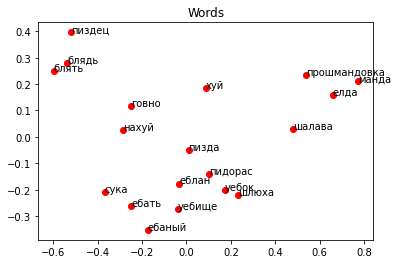

In [ ]:
plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Words')

for i, word in enumerate(words):
    plt.annotate(word, xy=(coords[i, 0], coords[i, 1]))
plt.show()

# Metadata

## Сравнение по полу автора

In [ ]:
df_women = df_meta[df_meta['Sex'] == 2]
df_men = df_meta[df_meta['Sex'] == 1]

(61767, 6)

In [ ]:
print('Men: \nNumber of comments with "блять": {}, number of comments with "блядь": {}\n'.format(df_men[df_men['type'] == 'блять'].shape[0], df_men[df_men['type'] == 'блядь'].shape[0]))
print('Women: \nNumber of comments with "блять": {}, number of comments with "блядь": {}'.format(df_women[df_women['type'] == 'блять'].shape[0], df_women[df_women['type'] == 'блядь'].shape[0]))

Men: 
Number of comments with "блять": 15622, number of comments with "блядь": 1738

Women: 
Number of comments with "блять": 50880, number of comments with "блядь": 8345


In [ ]:
women_corp = ' '.join(df_women['Tetx'])
men_corp = ' '.join(df_men['Tetx'])
len(women_corp), len(men_corp)

(7089492, 1827266)

In [ ]:
women_corp[:300]

'Марсианка блядь Дорогие бляди, у кого есть казлы имеющие проблемы с алкоголем, Я могу помочь вам. есть одно замечательное средство, лично проверенное моим казлом, за 3 недели отпоила и теперь никакого алкоголя. Кому интересно, Я подробнее написала у себЯ на страничке, заходите смотрите Просто больши'

In [ ]:
women_corp = re.sub('#', '', women_corp)
women_corp = re.sub('\[.+?\]', '', women_corp)
women_corp = women_corp.lower()
women_corp = re.sub('\d+', ' ', women_corp)
women_corp = re.sub('[-*]', '', women_corp)

women_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', women_corp)

words = re.findall('[А-Яа-я]+', women_corp)
women_corp = ' '.join(words)
women_corp[:300]

'марсианка блядь дорогие бляди у кого есть казлы имеющие проблемы с алкоголем я могу помочь вам есть одно замечательное средство лично проверенное моим казлом за недели отпоила и теперь никакого алкоголя кому интересно я подробнее написала у себя на страничке заходите смотрите просто большинство муда'

In [ ]:
men_corp = re.sub('#', '', men_corp)
men_corp = re.sub('\[.+?\]', '', men_corp)
men_corp = men_corp.lower()
men_corp = re.sub('\d+', ' ', men_corp)
men_corp = re.sub('[-*]', '', men_corp)

men_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', men_corp)

words = re.findall('[А-Яа-я]+', men_corp)
men_corp = ' '.join(words)
men_corp[:300]

'сколько агрессии даешь в задницу ты а блядь я ну да что ж тебе еще остается бедолага бля я на первом курсе ездила с огромной хуевиной деревянным планшетом размер см на в чехле рост у меня был и эта хуйня мне была почти по пояс в другой руке сумка и коробище с макетом мне очень редко место уступали я'

In [ ]:
with open('women_corpus.txt', 'w', encoding='utf-8') as fi_wo:
  fi_wo.write(women_corp)
with open('men_corpus.txt', 'w', encoding='utf-8') as fi_me:
  fi_me.write(men_corp)

In [ ]:
f1 = 'women_corpus.txt'
data_women = gensim.models.word2vec.LineSentence(f1)
f2 = 'men_corpus.txt'
data_men = gensim.models.word2vec.LineSentence(f2)

In [ ]:
%time model_women = gensim.models.Word2Vec(data_women, size=300, window=9, min_count=2)

CPU times: user 39.2 s, sys: 282 ms, total: 39.5 s
Wall time: 25.3 s


In [ ]:
%time model_men = gensim.models.Word2Vec(data_men, size=300, window=9, min_count=2)

CPU times: user 9.75 s, sys: 107 ms, total: 9.85 s
Wall time: 6.82 s


In [ ]:
model_women.init_sims(replace=True)
model_women_path = "model_women.bin"

print("Saving model for women...")
model_women.wv.save_word2vec_format(model_women_path, binary=True)

Saving model for women...


In [ ]:
model_men.init_sims(replace=True)
model_men_path = "model_men.bin"

print("Saving model for men...")
model_men.wv.save_word2vec_format(model_men_path, binary=True)

Saving model for men...


In [ ]:
model_women.wv.similarity('блядь', 'блять')

0.94524956

In [ ]:
model_men.wv.similarity('блядь', 'блять')

0.9898645

In [ ]:
model_women.wv.most_similar("блядь", topn=10)

[('блять', 0.945249617099762),
 ('админ', 0.9017140865325928),
 ('фу', 0.8698807954788208),
 ('удаляет', 0.8612380623817444),
 ('панчи', 0.8591217994689941),
 ('тойво', 0.8575912714004517),
 ('ой', 0.8574986457824707),
 ('отдашься', 0.8538258075714111),
 ('плез', 0.849617063999176),
 ('постирония', 0.8490432500839233)]

In [ ]:
model_women.wv.most_similar('блять', topn=10)

[('блядь', 0.945249617099762),
 ('админ', 0.8736746311187744),
 ('ой', 0.8676275610923767),
 ('фу', 0.8665794134140015),
 ('пустят', 0.8431378602981567),
 ('дио', 0.8353320360183716),
 ('пиджак', 0.8263695240020752),
 ('развидеть', 0.8248611092567444),
 ('пиздец', 0.8222665190696716),
 ('гусли', 0.8212090730667114)]

In [ ]:
model_men.wv.most_similar("блядь", topn=10)

[('сука', 0.9997944235801697),
 ('спойлер', 0.9988818764686584),
 ('че', 0.9985239505767822),
 ('пиздец', 0.9984306693077087),
 ('ела', 0.9981473684310913),
 ('черножопый', 0.9966488480567932),
 ('исполняете', 0.996501088142395),
 ('тук', 0.9961432814598083),
 ('издеваетесь', 0.9957300424575806),
 ('происходило', 0.9957165718078613)]

In [ ]:
model_men.wv.most_similar('блять', topn=10)

[('фу', 0.9983845949172974),
 ('нахуй', 0.9976086020469666),
 ('украине', 0.9942351579666138),
 ('голосину', 0.9942163228988647),
 ('че', 0.993499755859375),
 ('даша', 0.9934051036834717),
 ('годно', 0.9929912686347961),
 ('ела', 0.9922449588775635),
 ('овощ', 0.990668535232544),
 ('происходило', 0.9906144142150879)]

## Сравнение по возрастным группам

In [ ]:
import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
df_meta.sample(10)

,Id,Tetx,City,Sex,Bdate,type
1929,508064204,Не понял блядь,-,2,-,блядь
28282,617767218,чё за кринжуха блять),-,1,22.3.2002,блять
74878,102977951,"Бля, нытики в коментах в своём репертуаре, Бля...",-,2,2.2.1999,блять
21071,160852996,"[id310079830|Август], СПЕРМОБАКИ!!!!ХОДИМ, БЛЯ...",-,2,12.8.1902,блять
27347,611161474,Кто это блять?,-,2,23.7.2001,блять
8493,73502656,Чтоб они все сдохли блядь. Мерзость.,Magnitogorsk,2,-,блядь
57647,187211972,"Блять,как это разчитать?",-,2,11.1.1991,блять
75208,550599531,"[id500202869|Евгений], Обосрался блять, Обосра...",-,2,17.3.1998,блять
78367,135366291,Город Краснознаменск улица связистов 10 кварти...,-,2,-,блять
44286,316048267,Это блять кто?,-,2,-,блять


In [ ]:
df_age = df_meta[df_meta['Bdate'] != '-']
df_age.shape

(31199, 6)

In [ ]:
def get_age(bdate):
    datetime_bdate = datetime.datetime.strptime(bdate, '%d.%m.%Y')
    time_difference = relativedelta(datetime.datetime.today(), datetime_bdate)
    # age = datetime.datetime.today() - datetime_bdate
    return time_difference.years

In [ ]:
df_age['age'] = df_age['Bdate'].progress_apply(get_age)

100%|██████████| 31199/31199 [00:01<00:00, 28171.75it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_age.sample(5)

,Id,Tetx,City,Sex,Bdate,type,age
42165,524021089,"[club166624238|LIL3UCK], ахахахахахах,шутки пр...",-,2,29.7.2004,блять,16
49429,98208993,активный пользователь инстаграма - #лето #друз...,Yekaterinburg,2,13.1.1998,блять,23
4170,570757706,"[id406153382|Евгений], ты перхоть подзалупная,...",Tel Aviv,2,31.12.2000,блядь,20
26887,394168580,"[id603787196|Алексей], ты блять чушка африканская",Troitsk,2,18.2.2003,блять,18
41174,566052277,НУ КАНЬЕ БЛЯТЬ НУ ОНИ ЖЕ НЕ ПРОЗРАЧНЫЕ НУ БЛЯЯ...,Al Muḩarraq,2,16.10.1996,блять,24


In [ ]:
youngest = df_age[df_age['age'] < 21]
youngest_corp = ' '.join(youngest['Tetx'])
young = df_age[df_age['age'] > 20]
young = young[young['age'] < 31]
young_corp = ' '.join(young['Tetx'])
old = df_age[df_age['age'] > 30]
old_corp = ' '.join(old['Tetx'])

print(len(youngest_corp), len(young_corp), len(old_corp))

1471210 1417807 654939


In [ ]:
print('1-я возрастная группа: \nNumber of comments with "блять": {}, number of comments with "блядь": {}\n'.format(youngest[youngest['type'] == 'блять'].shape[0], youngest[youngest['type'] == 'блядь'].shape[0]))
print('2-я возрастная группа: \nNumber of comments with "блять": {}, number of comments with "блядь": {}\n'.format(young[young['type'] == 'блять'].shape[0], young[young['type'] == 'блядь'].shape[0]))
print('3-я возрастная группа: \nNumber of comments with "блять": {}, number of comments with "блядь": {}\n'.format(old[old['type'] == 'блять'].shape[0], old[old['type'] == 'блядь'].shape[0]))


1-я возрастная группа: 
Number of comments with "блять": 12011, number of comments with "блядь": 1177

2-я возрастная группа: 
Number of comments with "блять": 9906, number of comments with "блядь": 1775

3-я возрастная группа: 
Number of comments with "блять": 4355, number of comments with "блядь": 734



Люди до 20 лет употребляют "блять" в 10 раз чаще, чем "блядь"; люди от 20 до 30 - в 5,5; люди старше 30 - почти в 6 раз чаще. 

In [ ]:
youngest_corp = re.sub('#', '', youngest_corp)
youngest_corp = re.sub('\[.+?\]', '', youngest_corp)
youngest_corp = youngest_corp.lower()
youngest_corp = re.sub('\d+', ' ', youngest_corp)
youngest_corp = re.sub('[-*]', '', youngest_corp)

youngest_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', youngest_corp)

words = re.findall('[А-Яа-я]+', youngest_corp)
youngest_corp = ' '.join(words)
youngest_corp[:300]

'анилингус блядь админ да как ты заебал я бы тебе ебало набил мы хотим перчиков и тугосерь что за говно блядь всем похуй что она жрет пускай лучше говно тугосери навернет блядь репорт слон и моська блядь ор блядь обожаю эти фейковые файлообменники посмейтесь блядь блядь помидоры за хривен еб твою мат'

In [ ]:
young_corp = re.sub('#', '', young_corp)
young_corp = re.sub('\[.+?\]', '', young_corp)
young_corp = young_corp.lower()
young_corp = re.sub('\d+', ' ', young_corp)
young_corp = re.sub('[-*]', '', young_corp)

young_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', young_corp)

words = re.findall('[А-Яа-я]+', young_corp)
young_corp = ' '.join(words)
young_corp[:300]

'он же блядь не насрал на телефон то слыш блядь есть блядь просто хорошие психологи увлекающиеся физиогномикой и обладающие логическим мышлением о боже экстрасексы ничего скоро успокоится поймет свою ущербность пойдет поплачет и напишет фанфик о том какие женщины бляди и мрази ты такая ебнутая блядь '

In [ ]:
old_corp = re.sub('#', '', old_corp)
old_corp = re.sub('\[.+?\]', '', old_corp)
old_corp = old_corp.lower()
old_corp = re.sub('\d+', ' ', old_corp)
old_corp = re.sub('[-*]', '', old_corp)

old_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', old_corp)

words = re.findall('[А-Яа-я]+', old_corp)
old_corp = ' '.join(words)
old_corp[:300]

'я не удивлюсь если большинство срунов и ссунов среди баб мерзких и тошнотных созданий кровяные выбляди блядь тут только ты блядик было уже блядь мужиков блядей тоже хватает и что это хорошо бляди бляди оо о бляди бляди бляди блядские поноспонос бляди или блядь опоносилась или блядские месячныемесячн'

In [ ]:
with open('youngest_corpus.txt', 'w', encoding='utf-8') as fi_youngest:
  fi_youngest.write(youngest_corp)

with open('young_corpus.txt', 'w', encoding='utf-8') as fi_young:
  fi_young.write(young_corp)

with open('old_corpus.txt', 'w', encoding='utf-8') as fi_old:
  fi_old.write(old_corp)

f1 = 'youngest_corpus.txt'
data_youngest = gensim.models.word2vec.LineSentence(f1)
f2 = 'young_corpus.txt'
data_young = gensim.models.word2vec.LineSentence(f2)
f3 = 'old_corpus.txt'
data_old = gensim.models.word2vec.LineSentence(f3)

In [ ]:
model_youngest = gensim.models.Word2Vec(data_youngest, size=300, window=9, min_count=2)
model_young = gensim.models.Word2Vec(data_young, size=300, window=9, min_count=2)
model_old = gensim.models.Word2Vec(data_old, size=300, window=9, min_count=2)

In [ ]:
model_youngest.init_sims(replace=True)
model_youngest_path = "model_youngest.bin"
print("Saving model for 1st group...")
model_youngest.wv.save_word2vec_format(model_youngest_path, binary=True)

model_young.init_sims(replace=True)
model_young_path = "model_young.bin"
print("Saving model for 2nd group...")
model_young.wv.save_word2vec_format(model_young_path, binary=True)

model_old.init_sims(replace=True)
model_old_path = "model_old.bin"
print("Saving model for 3rd group...")
model_old.wv.save_word2vec_format(model_old_path, binary=True)

Saving model for 1st group...
Saving model for 2nd group...
Saving model for 3rd group...


In [ ]:
print('Similarity for 1st group: {}\nSimilarity for 2nd group: {}\nSimilarity for 3rd group: {}'.format(model_youngest.wv.similarity('блядь', 'блять'), model_young.wv.similarity('блядь', 'блять'), model_old.wv.similarity('блядь', 'блять')))

## Сравнение по городу





In [ ]:
df_more1b = df_meta[df_meta['City population'] > 999999]
df_less1b = df_meta[df_meta['City population'] <= 999999]

In [ ]:
print('More 1b city: \nNumber of comments with "блять": {}, number of comments with "блядь": {}\n'.format(df_more1b[df_more1b['type'] == 'блять'].shape[0], df_more1b[df_more1b['type'] == 'блядь'].shape[0]))
print('Less 1b city: \nNumber of comments with "блять": {}, number of comments with "блядь": {}'.format(df_less1b[df_less1b['type'] == 'блять'].shape[0], df_less1b[df_less1b['type'] == 'блядь'].shape[0]))

More 1b city: 
Number of comments with "блять": 19214, number of comments with "блядь": 2928

Less 1b city: 
Number of comments with "блять": 47302, number of comments with "блядь": 7156


In [ ]:
less1b_corp = ' '.join(df_less1b['Text'])
more1b_corp = ' '.join(df_more1b['Text'])
len(less1b_corp), len(more1b_corp)

(6249946, 2668115)

In [ ]:
less1b_corp[:300]

'Марсианка блядь Дорогие бляди, у кого есть казлы имеющие проблемы с алкоголем, Я могу помочь вам. есть одно замечательное средство, лично проверенное моим казлом, за 3 недели отпоила и теперь никакого алкоголя. Кому интересно, Я подробнее написала у себЯ на страничке, заходите смотрите Просто больши'

In [ ]:
less1b_corp = re.sub('#', '', less1b_corp)
less1b_corp = re.sub('\[.+?\]', '', less1b_corp)
less1b_corp = less1b_corp.lower()
less1b_corp = re.sub('\d+', ' ', less1b_corp)
less1b_corp = re.sub('[-*]', '', less1b_corp)

less1b_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', less1b_corp)

words = re.findall('[А-Яа-я]+', less1b_corp)
less1b_corp = ' '.join(words)
less1b_corp[:300]

'марсианка блядь дорогие бляди у кого есть казлы имеющие проблемы с алкоголем я могу помочь вам есть одно замечательное средство лично проверенное моим казлом за недели отпоила и теперь никакого алкоголя кому интересно я подробнее написала у себя на страничке заходите смотрите просто большинство муда'

In [ ]:
more1b_corp = re.sub('#', '', more1b_corp)
more1b_corp = re.sub('\[.+?\]', '', more1b_corp)
more1b_corp = more1b_corp.lower()
more1b_corp = re.sub('\d+', ' ', more1b_corp)
more1b_corp = re.sub('[-*]', '', more1b_corp)

more1b_corp = re.sub('[!"#$%&\'()+,./:;<=>?@[\]^_`{|}~]', ' ', more1b_corp)

words = re.findall('[А-Яа-я]+', more1b_corp)
more1b_corp = ' '.join(words)
more1b_corp[:300]

'сколько агрессии даешь в задницу ты а блядь я ну да что ж тебе еще остается бедолага бля я на первом курсе ездила с огромной хуевиной деревянным планшетом размер см на в чехле рост у меня был и эта хуйня мне была почти по пояс в другой руке сумка и коробище с макетом мне очень редко место уступали я'

In [ ]:
with open('more1b_corpus.txt', 'w', encoding='utf-8') as fi_more:
  fi_more.write(more1b_corp)
with open('less1b_corpus.txt', 'w', encoding='utf-8') as fi_less:
  fi_less.write(less1b_corp)

In [ ]:
f1 = 'more1b_corpus.txt'
data_more = gensim.models.word2vec.LineSentence(f1)
f2 = 'less1b_corpus.txt'
data_less = gensim.models.word2vec.LineSentence(f2)

In [ ]:
%time model_more = gensim.models.Word2Vec(data_more, size=300, window=9, min_count=2)

CPU times: user 15.1 s, sys: 84.2 ms, total: 15.2 s
Wall time: 10.3 s


In [ ]:
%time model_less = gensim.models.Word2Vec(data_less, size=300, window=9, min_count=2)

CPU times: user 35.6 s, sys: 314 ms, total: 35.9 s
Wall time: 23.1 s


In [ ]:
model_less.init_sims(replace=True)
model_less_path = "model_less.bin"

print("Saving model for cities less 1b...")
model_less.wv.save_word2vec_format(model_less_path, binary=True)

Saving model for cities less 1b...


In [ ]:
model_more.init_sims(replace=True)
model_more_path = "model_more.bin"

print("Saving model for cities more 1b...")
model_more.wv.save_word2vec_format(model_more_path, binary=True)

Saving model for cities more 1b...


In [ ]:
model_more.wv.similarity('блядь', 'блять')

0.98077214

In [ ]:
model_less.wv.similarity('блядь', 'блять')

0.93749535

In [ ]:
model_more.wv.most_similar("блядь", topn=10)

[('продолжение', 0.9866150617599487),
 ('щенок', 0.9856469631195068),
 ('блчть', 0.9836873412132263),
 ('ахуительно', 0.9835828542709351),
 ('репост', 0.9822808504104614),
 ('шься', 0.9822662472724915),
 ('окр', 0.9821023941040039),
 ('блять', 0.9807721376419067),
 ('трогай', 0.9787279963493347),
 ('пупка', 0.9776377081871033)]

In [ ]:
model_more.wv.most_similar('блять', topn=10)

[('фу', 0.9832509756088257),
 ('зашкварное', 0.9812309741973877),
 ('блядь', 0.9807721376419067),
 ('удаляет', 0.9800307750701904),
 ('кушал', 0.9789137244224548),
 ('пиздец', 0.9786537885665894),
 ('где', 0.9782518744468689),
 ('доказано', 0.9770193099975586),
 ('ис', 0.976982593536377),
 ('че', 0.9768842458724976)]

In [ ]:
model_less.wv.most_similar("блядь", topn=10)

[('блять', 0.9374954700469971),
 ('админ', 0.9122676849365234),
 ('лейлой', 0.9027143716812134),
 ('стрпницу', 0.8967263698577881),
 ('сукаааааа', 0.8960633277893066),
 ('фу', 0.8954200744628906),
 ('ой', 0.8935791254043579),
 ('откопали', 0.8900841474533081),
 ('отупел', 0.888058066368103),
 ('ничья', 0.8872628211975098)]

In [ ]:
model_less.wv.most_similar('блять', topn=10)

[('блядь', 0.9374954700469971),
 ('ой', 0.8696398735046387),
 ('ничья', 0.8683974742889404),
 ('ауешников', 0.8642392158508301),
 ('прочла', 0.8554661870002747),
 ('сукаааааа', 0.8508602380752563),
 ('геркулес', 0.8504762649536133),
 ('фу', 0.8491173982620239),
 ('ро', 0.8467000126838684),
 ('админ', 0.8460150957107544)]